In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import parent
import networks

In [2]:
from collections import OrderedDict
import torch.nn.functional as F
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import inverseConsistentNet
import networks
import network_wrappers
import data
import numpy as np
import matplotlib.pyplot as plt

In [3]:
r_ds = torch.load("/playpen/tgreer/knees_test_set")
batched_ds = list(zip(*[r_ds[i::8] for i in range(8)]))

In [4]:
BATCH_SIZE = 32
SCALE = 1  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

GPUS = 4


phi = network_wrappers.FunctionFromVectorField(
    networks.tallUNet(unet=networks.UNet2ChunkyMiddle, dimension=3)
)
psi = network_wrappers.FunctionFromVectorField(
    networks.tallUNet2(dimension=3)
)

net = inverseConsistentNet.InverseConsistentNet(
    network_wrappers.DoubleNet(phi, psi),
    lambda x, y: torch.mean((x - y) ** 2),
    100,
)

network_wrappers.assignIdentityMap(net, input_shape)

/playpen-raid1/tgreer/InverseConsistency/networks.py:483: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([[2, 16, 32, 64, 256, 512], [16, 32, 64, 128, 256]]),


In [5]:
def adjust_batch_size(model, size):
    shape = model.input_shape
    shape[0] = size
    network_wrappers.assignIdentityMap(model, shape)
adjust_batch_size(net, 32)

#trained_weights = torch.load("../results/dd_l400_continue_rescalegrad2/knee_aligner_resi_net24600")
#trained_weights = torch.load("../results/dd_knee_l400_continue_smallbatch2/knee_aligner_resi_net9300")
#trained_weights = torch.load("../results/double_deformable_knee3/knee_aligner_resi_net9600")
#trainied_weights = torch.load("../results/just_upsample_3/knee_aligner_resi_net15900")
#trained_weights = torch.load("../../masked_similarity_InvCon/results/onChungusGpu/knee_aligner_resi_net10200")
#trained_weights = torch.load("../../masked_similarity_InvCon/results/smart_flip_detection_2/knee_aligner_resi_net6300")
#trained_weights = torch.load("../../masked_similarity_InvCon/results/smart_lmbda_4/knee_aligner_resi_net16200")
trained_weights = torch.load("../../masked_similarity_InvCon/results/blurred_input_ddk_lowres/knee_aligner_resi_net24600")
#trained_weights = torch.load("../../masked_similarity_InvCon/results/noisy_inverse_consistency.pyt/knee_aligner_resi_net23400")

In [6]:
net.load_state_dict(trained_weights)

<All keys matched successfully>

In [7]:
adjust_batch_size(net, 8)
net.cuda()
net.eval()
0

0

In [8]:
bl = torch.nn.Conv3d(1, 1, 3, padding=1, padding_mode="replicate")



torch.nn.init.zeros_(bl.bias)

with torch.no_grad():
    bl.weight[:] = torch.tensor(np.array(
              [[[[[1, 2, 1],
                  [2, 4, 2],
                  [1, 2, 1]],
                 [[2, 4, 2],
                  [4, 8, 4],
                  [2, 4, 2]],
                 [[1, 2, 1],
                  [2, 4, 2],
                  [1, 2, 1]]]]], dtype=np.float32)) / 64
    
bl.cuda()

Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), padding_mode=replicate)

In [9]:
def flips(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True)
    return torch.sum(dV < 0) / BATCH_SIZE
dices = []
flipsl = []
for x in batched_ds[:]:
    x = list(zip(*x))
    x = [torch.cat(r, 0).cuda().float() for r in x]
    fixed_image, fixed_cartilage = bl(x[0]), bl(x[2])
    moving_image, moving_cartilage = x[1], x[3]
    
    net(moving_image, fixed_image)
    fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(net.phi_AB(net.identityMap)[:, :3])
    sz = np.array(fat_phi.size())
    spacing = 1./(sz[2::]-1) 
    warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)
    wmb = warped_moving_cartilage > .5
    fb = fixed_cartilage > .5
    intersection = wmb * fb
    d = 2 * torch.sum(intersection).float() / (torch.sum(wmb) + torch.sum(fb))
    print(d)
    dices.append(d)
    print(flips(fat_phi) // 8)
    flipsl.append(flips(fat_phi) // 8)
dd = np.mean([d.item() for d in dices])
print(dd)

/playpen-raid1/tgreer/anaconda3/envs/mermaid5/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor(0.5892, device='cuda:0')
tensor(44., device='cuda:0')
tensor(0.6226, device='cuda:0')
tensor(39., device='cuda:0')
tensor(0.5136, device='cuda:0')
tensor(78., device='cuda:0')
tensor(0.6029, device='cuda:0')
tensor(96., device='cuda:0')
tensor(0.5670, device='cuda:0')
tensor(173., device='cuda:0')
tensor(0.5705, device='cuda:0')
tensor(71., device='cuda:0')
tensor(0.5395, device='cuda:0')
tensor(62., device='cuda:0')
tensor(0.6000, device='cuda:0')
tensor(65., device='cuda:0')
tensor(0.6106, device='cuda:0')
tensor(44., device='cuda:0')
tensor(0.5971, device='cuda:0')
tensor(147., device='cuda:0')
tensor(0.5218, device='cuda:0')
tensor(72., device='cuda:0')
tensor(0.5855, device='cuda:0')
tensor(65., device='cuda:0')
tensor(0.5999, device='cuda:0')
tensor(99., device='cuda:0')
tensor(0.5658, device='cuda:0')
tensor(132., device='cuda:0')
tensor(0.5638, device='cuda:0')
tensor(78., device='cuda:0')
tensor(0.5349, device='cuda:0')
tensor(279., device='cuda:0')
tensor(0.5812, devic

In [ ]:
old:5936
blur:.55 (.56)
noise:0.5925716596680719
    

In [10]:
np.mean([f.item() for f in flipsl])

87.83783783783784

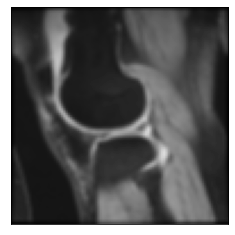

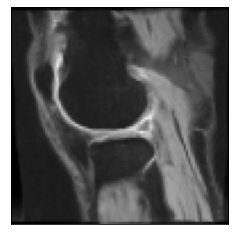

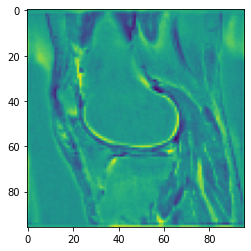

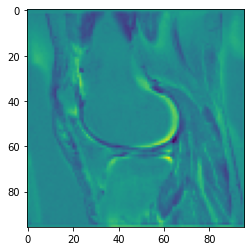

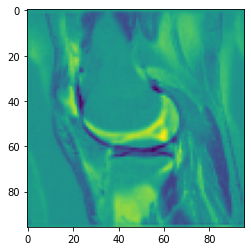

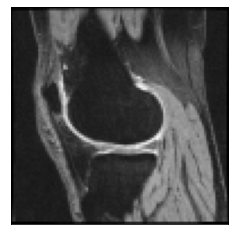

In [11]:
if not("N" in locals()):
    N = 0
N += 1
N %= 8
#plt.imshow(fixed_image[N, 0, 10].cpu() - net.warped_image_A[N, 0, 10].cpu().detach())
#plt.show()
plt.rcParams["figure.figsize"] = (4, 4)
def imshow(x):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.abs(x.cpu().detach()), vmin=0, vmax=1, cmap="gray")
slice_ = 10
imshow(fixed_image[N, 0, slice_])
plt.show()
imshow(net.warped_image_A[N, 0, slice_])
plt.show()

plt.imshow(net.warped_image_B[N, 0, slice_].cpu().detach() - moving_image[N, 0, slice_].cpu().detach())
plt.show()
plt.imshow(net.regis_net.x_comp_phi[N, 0, slice_].cpu().detach() - moving_image[N, 0, slice_].cpu().detach())
plt.show()
plt.imshow((fixed_image - moving_image)[N, 0, slice_].cpu().detach())
plt.show()

imshow(moving_image[N, 0, slice_].cpu().detach())
plt.show()

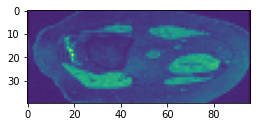

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

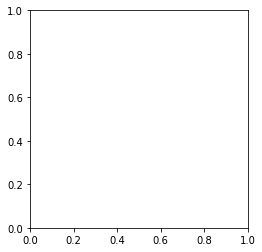

In [12]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())
plt.show()

plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach() - moving_image[0, 0, :, 10].cpu())

In [ ]:
N +=1
N %= 8
S = 40
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow((warped_moving_cartilage[N, 0, :, S * 4].detach().cpu() - fixed_cartilage[N, 0, :, S * 4].cpu()))
plt.show()

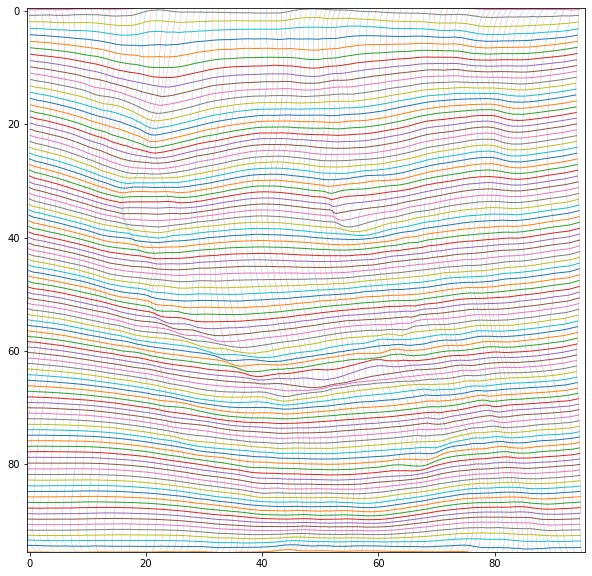

In [13]:
import visualize
N = (N + 1)% 8
plt.rcParams["figure.figsize"] = 10, 10
visualize.show_as_grid(net.phi_AB_vectorfield[N, [1, 2], 10])

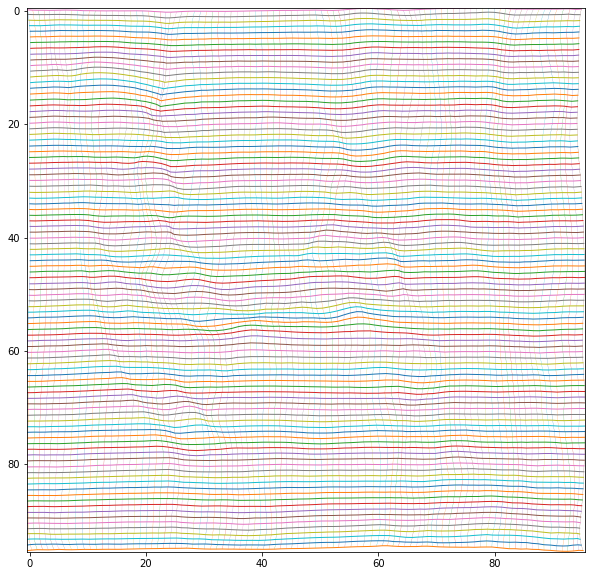

In [14]:
phi = net.phi_AB.__closure__[1]
some_vectorfield = phi.cell_contents.__closure__[1].cell_contents + net.identityMap
visualize.show_as_grid(some_vectorfield[N, [1, 2], 20])

In [134]:
net.phi_AB.__closure__[0].cell_contents

<function network_wrappers.FunctionFromVectorField.forward.<locals>.ret(input_)>

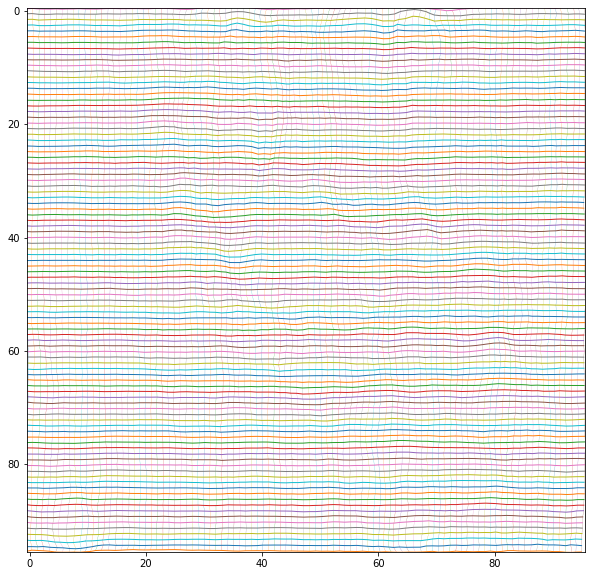

In [15]:
N = (N + 1) % 8
visualize.show_as_grid(net.phi_BA(net.phi_AB(net.identityMap))[N, [1, 2], 30])

In [128]:
type(net.regisNet.netPhi)

ModuleAttributeError: 'InverseConsistentNet' object has no attribute 'regisNet'

In [129]:
net.lmbda

100

In [130]:
trained_weights.keys()

odict_keys(['identityMap', 'regis_net.identityMap', 'regis_net.netPsi.identityMap', 'regis_net.netPsi.net.identityMap', 'regis_net.netPsi.net.downConvs.0.weight', 'regis_net.netPsi.net.downConvs.0.bias', 'regis_net.netPsi.net.downConvs.1.weight', 'regis_net.netPsi.net.downConvs.1.bias', 'regis_net.netPsi.net.downConvs.2.weight', 'regis_net.netPsi.net.downConvs.2.bias', 'regis_net.netPsi.net.downConvs.3.weight', 'regis_net.netPsi.net.downConvs.3.bias', 'regis_net.netPsi.net.downConvs.4.weight', 'regis_net.netPsi.net.downConvs.4.bias', 'regis_net.netPsi.net.upConvs.0.weight', 'regis_net.netPsi.net.upConvs.0.bias', 'regis_net.netPsi.net.upConvs.1.weight', 'regis_net.netPsi.net.upConvs.1.bias', 'regis_net.netPsi.net.upConvs.2.weight', 'regis_net.netPsi.net.upConvs.2.bias', 'regis_net.netPsi.net.upConvs.3.weight', 'regis_net.netPsi.net.upConvs.3.bias', 'regis_net.netPsi.net.upConvs.4.weight', 'regis_net.netPsi.net.upConvs.4.bias', 'regis_net.netPsi.net.batchNorms.0.weight', 'regis_net.netPs

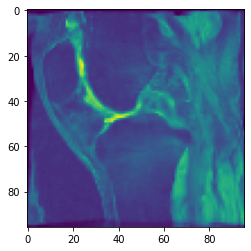

In [162]:
plt.imshow(net.warped_image_B[0, 0, 20].cpu().detach())

In [112]:
def flips2(phi):
    a = phi[:, :, 1:, 1:, 1:] - phi[:, :, :-1, 1:, 1:]
    b = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, :-1, 1:]
    c = phi[:, :, 1:, 1:, 1:] - phi[:, :, 1:, 1:, :-1]

    dV = torch.sum(torch.cross(a, b, 1) * c, axis=1, keepdims=True) / np.product(net.spacing)
    return dV.detach().cpu()

dV = flips2(net.phi_AB_vectorfield)

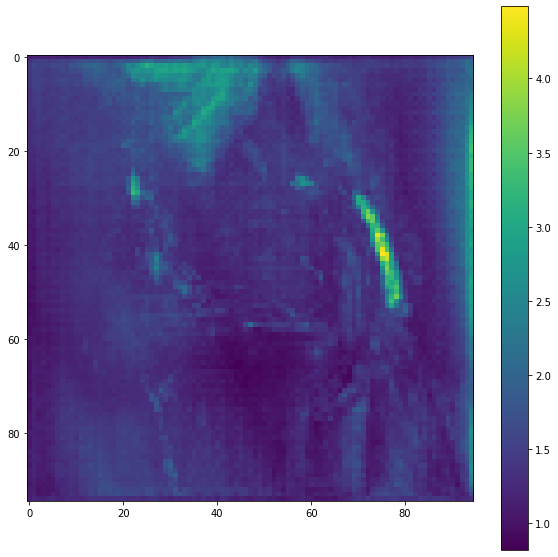

In [122]:
plt.imshow(torch.max(dV[2, 0], axis=0).values)
plt.colorbar()

In [95]:
torch.min(dV[0, 0], axis=2).values

tensor([[9.0962e-07, 1.3922e-06, 1.9076e-06,  ..., 2.0819e-06, 1.6802e-06,
         1.6636e-06],
        [9.6025e-07, 1.2300e-06, 1.3677e-06,  ..., 2.0941e-06, 1.6396e-06,
         1.8732e-06],
        [1.0567e-06, 1.1886e-06, 1.3409e-06,  ..., 2.0042e-06, 1.5364e-06,
         1.7836e-06],
        ...,
        [1.1789e-06, 8.0111e-07, 9.2926e-07,  ..., 1.9860e-06, 1.7852e-06,
         1.5311e-06],
        [1.2862e-06, 1.0192e-06, 1.1178e-06,  ..., 1.9306e-06, 1.7918e-06,
         1.6268e-06],
        [1.6100e-06, 1.3876e-06, 1.3956e-06,  ..., 2.1676e-06, 2.2221e-06,
         2.0933e-06]])

In [151]:
len(net.input_shape) - 2 == 3

True

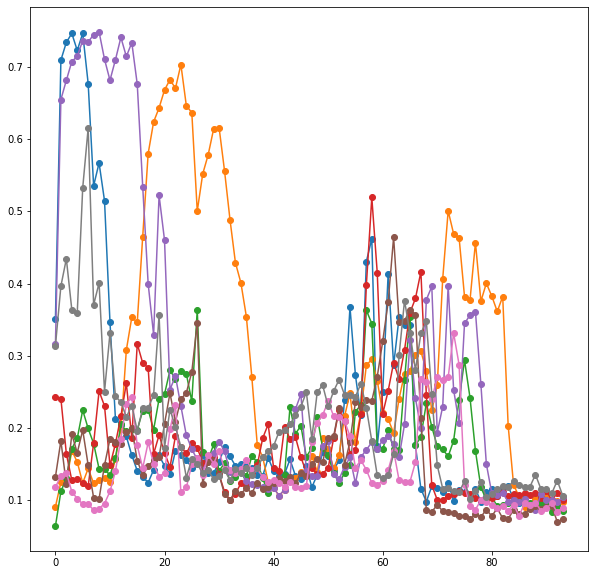

In [171]:
plt.plot(moving_image[:, 0, 20, 1:-1, 20].detach().cpu().transpose(0, 1), marker='o')
plt.show()

In [60]:
len(r_ds)

301

In [61]:
train_data = torch.load("/playpen/tgreer/knees_big_train_set")

In [62]:
len(train_data)

2532